In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, PredictionErrorDisplay
from tensorflow.keras.datasets import mnist

import autokeras as ak
pd.set_option('display.max_columns', None)

from IPython.display import SVG, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the hang of the workflow using the mnist data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
[5 0 4]


In [5]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)

# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

2023-12-13 18:10:08.459967: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
vanilla           |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
False             |False             |image_block_1/augment
3                 |3                 |image_block_1/conv_block_1/kernel_size
1                 |1                 |image_block_1/conv_block_1/num_blocks
2                 |2                 |image_block_1/conv_block_1/num_layers
True              |True              |image_block_1/conv_block_1/max_pooling
False             |False             |image_block_1/conv_block_1/separable
0.25              |0.25              |image_block_1/conv_block_1/dropout
32                |32                |image_block_1/conv_block_1/filters_0_0
64                |64                |image_block_1/conv_block_1/filters_0_1
flatten           |flatten           |classification_head_1/spatial_reduction_1/reduction_type
0.5               |0.5          

KeyboardInterrupt: 

# Now work with PTA jMSFS. Here is a function to load the simulations and reshape the jmsfs to what tf expects

In [32]:
def load_simulations(simfile, nrows=None, npops=4, nsamps=(3,2)):
    """
    Load in the simulation data, if it exists.
    """
    dat = pd.read_csv(simfile, sep=" ")

    if nrows == None:
        nrows = len(dat)

    # Split the params and jsfs data
    # The dataframe is formated so that the first bin of the jMSFS is 0
    idx = dat.columns.get_loc('0')
    params = dat.iloc[:nrows, :idx]
    jmsfs = dat.iloc[:nrows, idx:]
    nrows = min(len(jmsfs), nrows)
    jmsfs = jmsfs.values.reshape(nrows,
                        npops,
                        nsamps[0]*2+1,
                        nsamps[1]*2+1)
    # Note: Autokeras expects the structure of the data to be slightly different so we have to shift around the axes
    jmsfs = np.swapaxes(jmsfs, 1, 3)
    jmsvs = np.swapaxes(jmsfs, 1, 2)

    return params, jmsfs
params, jmsfs = load_simulations("./default_PTA/2D-test-SIMOUT.csv", npops=4, nsamps=(3,2))
print(len(params), jmsfs.shape)
params

1000 (1000, 5, 7, 4)


,zeta,zeta_e,r_moderns_mean,r_moderns_std,r_moderns_skewness,r_moderns_kurtosis,r_moderns_median,r_moderns_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr
0,0.225,1,0.0,0.0,0.0,-3.0,0.0,0.0,358377.825,252269.550,0.227,-1.024,338769.445,228311.756
1,0.306,2,0.0,0.0,0.0,-3.0,0.0,0.0,164354.344,147496.934,0.286,-1.616,135422.804,241304.794
2,0.918,4,0.0,0.0,0.0,-3.0,0.0,0.0,376412.025,142812.901,-0.820,-0.900,421939.931,138175.568
3,0.312,2,0.0,0.0,0.0,-3.0,0.0,0.0,74413.308,91653.311,1.152,-0.669,23149.243,57423.241
4,0.761,4,0.0,0.0,0.0,-3.0,0.0,0.0,178215.235,157090.487,0.317,-1.551,148495.130,247141.643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.802,4,0.0,0.0,0.0,-3.0,0.0,0.0,591380.266,347931.090,-0.712,-1.068,699749.342,420225.348
996,0.262,2,0.0,0.0,0.0,-3.0,0.0,0.0,278055.833,321048.441,1.015,-0.789,133405.627,303263.634
997,0.416,2,0.0,0.0,0.0,-3.0,0.0,0.0,293576.428,267654.814,0.027,-1.949,282229.315,503716.024
998,0.419,2,0.0,0.0,0.0,-3.0,0.0,0.0,143631.955,92350.358,0.729,-0.940,118240.045,90112.543


# A very hackish and "by-hand" test/train split routine

In [33]:
# Set the name of the target parameter here if you want to change it
z = params["zeta_e"]

idx = 750
x_train = jmsfs[:idx]
y_train = z[:idx]
x_test = jmsfs[idx:]
y_test = z[idx:]
print(np.shape(x_train))
x_train[0]

(750, 5, 7, 4)


array([[[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.511e+03, 8.355e+02, 6.715e+02, 5.100e+01],
        [3.355e+02, 2.800e+02, 2.035e+02, 1.250e+01],
        [1.830e+02, 1.090e+02, 5.450e+01, 9.000e+00],
        [2.650e+01, 1.600e+01, 6.000e+00, 1.500e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],

       [[8.395e+02, 8.105e+02, 3.055e+02, 2.700e+01],
        [7.285e+02, 5.860e+02, 4.430e+02, 1.400e+01],
        [4.820e+02, 3.480e+02, 2.290e+02, 6.900e+01],
        [2.680e+02, 9.800e+01, 4.750e+01, 2.600e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],

       [[1.300e+02, 8.200e+01, 2.650e+01, 2.650e+01],
        [2.560e+02, 2.330e+02, 1.375e+02, 7.500e+00],
        [6.040e+02, 1.265e+02, 2.550e+01, 2.400e+01],
        [3.450e+02, 1.065e+02, 1.060e+02, 1.000e+00],
        [0.000e+00, 0.00

# Run a classifier (works for zeta_e becuase its int values are converted to categorical)

In [34]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)

# Predict with the best model.
predicted_y = clf.predict(x_test)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

Trial 1 Complete [00h 00m 12s]
val_loss: 1.3794869184494019

Best val_loss So Far: 1.3794869184494019
Total elapsed time: 00h 00m 12s
Epoch 1/10
24/24 [==============================] - 2s 18ms/step - loss: 1.4557 - accuracy: 0.2667
Epoch 2/10
24/24 [==============================] - 0s 13ms/step - loss: 1.3871 - accuracy: 0.2773
Epoch 3/10
24/24 [==============================] - 0s 14ms/step - loss: 1.3669 - accuracy: 0.2920
Epoch 4/10
24/24 [==============================] - 0s 14ms/step - loss: 1.3596 - accuracy: 0.2880
Epoch 5/10
24/24 [==============================] - 0s 12ms/step - loss: 1.3542 - accuracy: 0.3147
Epoch 6/10
24/24 [==============================] - 0s 17ms/step - loss: 1.3554 - accuracy: 0.3227
Epoch 7/10
24/24 [==============================] - 1s 21ms/step - loss: 1.3477 - accuracy: 0.3293
Epoch 8/10
24/24 [==============================] - 0s 16ms/step - loss: 1.3272 - accuracy: 0.3667
Epoch 9/10
24/24 [==============================] - 0s 17ms/step - loss: 1

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


8/8 [==============================] - 0s 6ms/step
[['1']
 ['3']
 ['3']
 ['3']
 ['2']
 ['2']
 ['4']
 ['1']
 ['1']
 ['3']
 ['4']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['2']
 ['3']
 ['3']
 ['2']
 ['1']
 ['3']
 ['1']
 ['3']
 ['4']
 ['1']
 ['2']
 ['2']
 ['3']
 ['2']
 ['2']
 ['2']
 ['4']
 ['2']
 ['4']
 ['3']
 ['3']
 ['4']
 ['2']
 ['2']
 ['1']
 ['3']
 ['1']
 ['1']
 ['2']
 ['3']
 ['1']
 ['2']
 ['1']
 ['3']
 ['1']
 ['2']
 ['3']
 ['3']
 ['4']
 ['2']
 ['4']
 ['2']
 ['1']
 ['1']
 ['4']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['3']
 ['1']
 ['2']
 ['1']
 ['1']
 ['2']
 ['1']
 ['2']
 ['4']
 ['3']
 ['2']
 ['1']
 ['3']
 ['4']
 ['1']
 ['3']
 ['1']
 ['2']
 ['2']
 ['1']
 ['2']
 ['2']
 ['1']
 ['4']
 ['3']
 ['1']
 ['1']
 ['3']
 ['4']
 ['1']
 ['1']
 ['4']
 ['1']
 ['4']
 ['2']
 ['4']
 ['1']
 ['4']
 ['3']
 ['3']
 ['4']
 ['2']
 ['1']
 ['3']
 ['4']
 ['1']
 ['1']
 ['3']
 ['1']
 ['1']
 ['1']
 ['1']
 ['2']
 ['2']
 ['1']
 ['2']
 ['3']
 ['1']
 ['3']
 ['3']
 ['1']
 ['3']
 ['3']
 ['2']
 ['1']
 ['2']
 ['4']
 ['1

/tmp/ipykernel_441639/3977850645.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ConfusionMatrixDisplay.from_predictions(y_test, [int(x) for x in predicted_y], cmap="Greys", normalize="true")


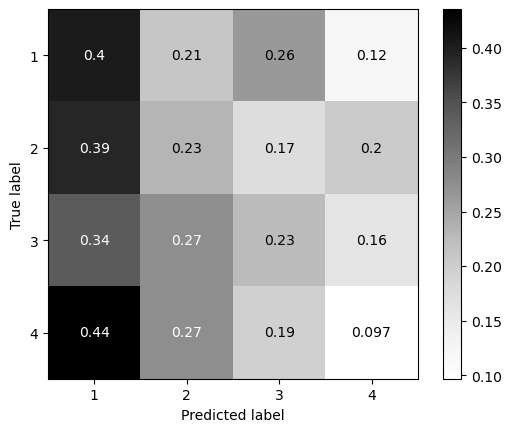

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, [int(x) for x in predicted_y], cmap="Greys", normalize="true")

# Regression
Here we can set the target to average Ne across all species, which is continuous valued so you can do regression on it

In [76]:
z = params["Ne_s_mean"]
idx = 750
x_train = jmsfs[:idx]
y_train = np.log(z[:idx])
x_test = jmsfs[idx:]
y_test = np.log(z[idx:])
print(np.shape(x_train))
x_train[0]

# Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=2)
# Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=2)

# Predict with the best model.
predicted_y = reg.predict(x_test)

# Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))

Trial 2 Complete [00h 21m 41s]
val_loss: 40193.85546875

Best val_loss So Far: 40193.85546875
Total elapsed time: 00h 41m 42s
Epoch 1/2
24/24 [==============================] - 679s 26s/step - loss: 876.8624 - mean_squared_error: 876.8624
Epoch 2/2
24/24 [==============================] - 670s 28s/step - loss: 8.3304 - mean_squared_error: 8.3304
INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


8/8 [==============================] - 63s 8s/step - loss: 1255.4854 - mean_squared_error: 1255.4854
[1255.4853515625, 1255.4853515625]


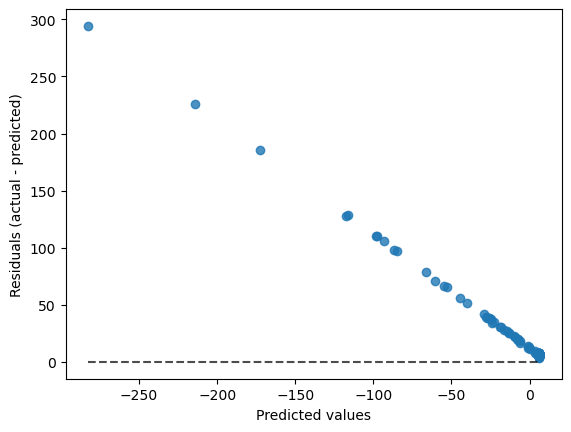

In [78]:
#tmp_ytest = y_test.ravel()
#np.random.shuffle(tmp_ytest)
PredictionErrorDisplay.from_predictions(y_test, predicted_y.ravel(), kind="residual_vs_predicted")